In [101]:
import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt 
from loaders import ItemLoader
from collections import defaultdict,Counter
import random
import numpy as np
import pickle
from openai import OpenAI
from testing import Tester
import re

In [102]:
load_dotenv(override=True)
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN')
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

openai = OpenAI()

In [103]:
login(os.environ['HF_TOKEN'],add_to_git_credential=True)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: Environment variable`H

In [104]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_Appliances", split='full', trust_remote_code=True)

In [105]:
len(dataset)

94327

In [106]:
not_none_prices_data = [float(price) for price in dataset['price'] if price != 'None']
percentage_not_none = len(not_none_prices_data)/len(dataset) * 100
print(f"{percentage_not_none: .1f} of the dataset does not have None price")

 49.5 of the dataset does not have None price


In [107]:
content = [data['title'] + str(data['description']) + str(data['features']) +str (data['details']) + data['price'] for data in dataset if data['price'] != None]

In [108]:
lengths = [len(data['title'] + str(data['description']) + str(data['features']) +str (data['details']) + data['price']) for data in dataset if data['price'] != None]

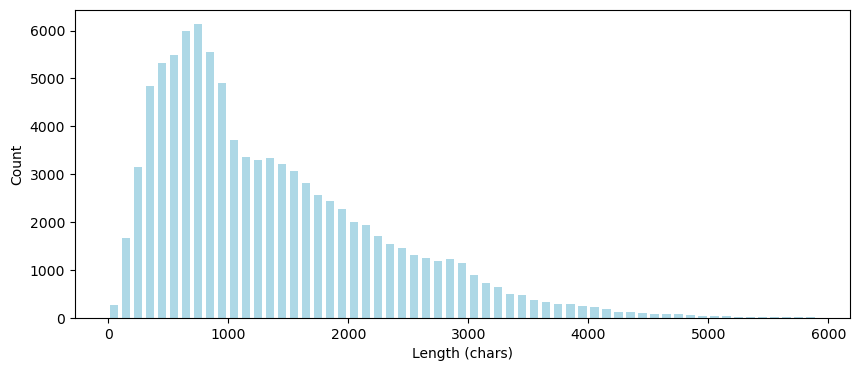

In [109]:
plt.figure(figsize=(10,4))
plt.hist(lengths, rwidth=0.7, color="lightblue", bins=range(0, 6000, 100))
plt.xlabel('Length (chars)')
plt.ylabel('Count')
plt.show()


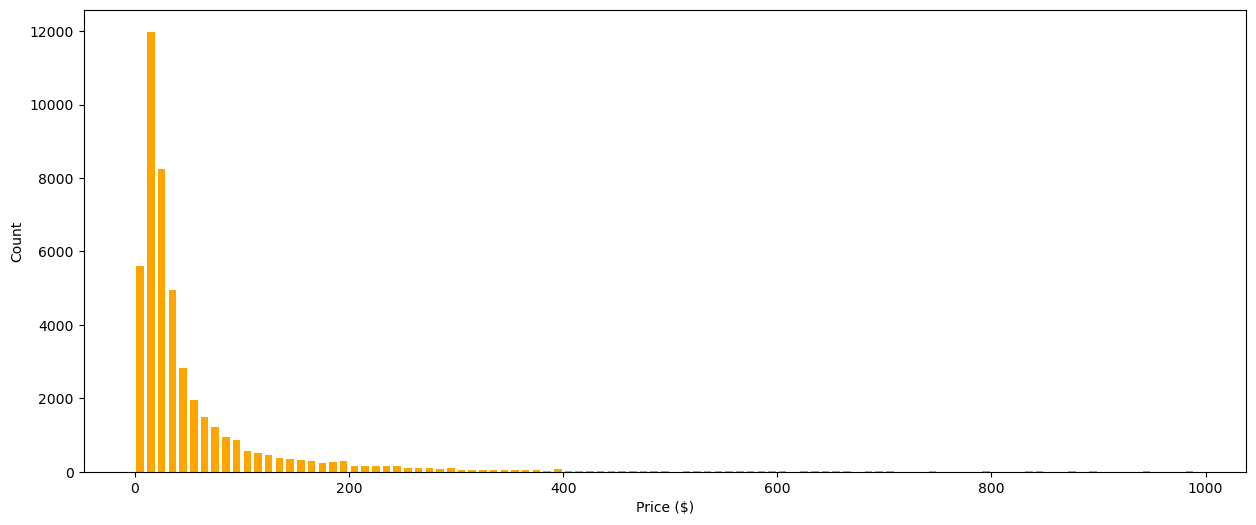

In [110]:
plt.figure(figsize=(15, 6))
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(not_none_prices_data, rwidth=0.7, color="orange", bins=range(0, 1000, 10))
plt.show()

In [111]:

from items import Item
items = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            item = Item(datapoint, price)
            if item.include:
                items.append(item)
    except ValueError as e:
        pass

print(f"There are {len(items):,} items")

There are 29,191 items


In [112]:
print(items[0])

<WD12X10327 Rack Roller and stud assembly Kit (4 Pack) by AMI PARTS Replaces AP4980629 PS3486910 1811003 = $8.99>


In [113]:
print(items[1000].test_prompt())

How much does this cost to the nearest dollar?

GE 18 Energy Star Portable Dishwasher with 8 Place Settings Autosense Cycle Pocket Handle and 53 dBA in Stainless Steel
GE Appliances is your home for the best kitchen appliances, home products, parts and accessories, and support. Autosense Cycle Piranha Hard Food Disposer Sanitize option (NSF Certified) Dimensions 36 H x 18 W x 25 3/8 D Autosense Cycle A beam of light measures soil levels and water temperature to adjust to the ideal cycle time Sanitize option (NSF Certified) High-temperature rinse sanitizes and reduces by the bacteria found on dishes Piranha Hard Food Disposer To ensure consistently clean items, this stainless steel blade rotates at 3,600 RPM to pulverize food particles and helps to prevent large particles from

Price is $


In [114]:
print(items[1000])

<GE GPT145SSLSS 18" Energy Star Portable Dishwasher with 8 Place Settings Autosense Cycle Pocket Handle and 53 dBA in Stainless Steel = $799.0>


In [115]:
dataset_names = [
#  "Automotive",
#     "Electronics",
#     "Office_Products",
#     "Tools_and_Home_Improvement",
    "Cell_Phones_and_Accessories",
    "Toys_and_Games",
    "Appliances"
    # "Musical_Instruments",

]

In [116]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

Loading dataset Cell_Phones_and_Accessories


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Completed Cell_Phones_and_Accessories with 238,869 datapoints in 0.9 mins
Loading dataset Toys_and_Games


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Completed Toys_and_Games with 340,479 datapoints in 1.1 mins
Loading dataset Appliances


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Completed Appliances with 28,625 datapoints in 0.2 mins


In [120]:
len(items)

607973

(array([2.00000e+00, 1.00000e+00, 3.00000e+00, 1.80000e+01, 1.40100e+03,
        2.71200e+03, 2.70000e+03, 3.15300e+03, 1.02401e+05, 4.95582e+05]),
 array([159., 161., 163., 165., 167., 169., 171., 173., 175., 177., 179.]),
 <BarContainer object of 10 artists>)

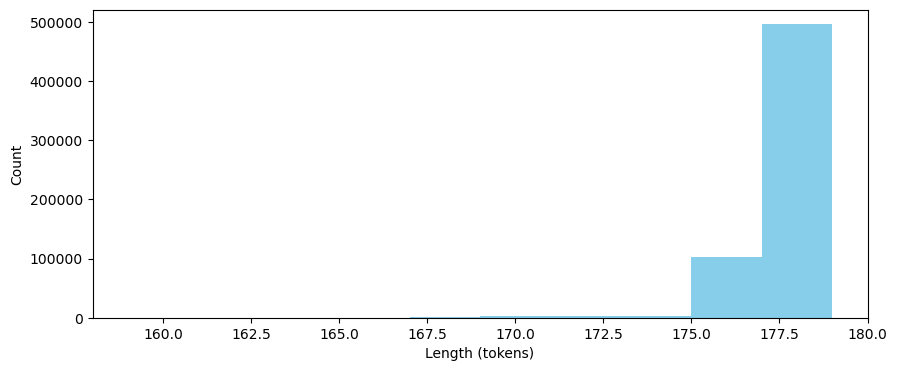

In [121]:
tokens = [item.token_count for item in items]
plt.figure(figsize=(10,4))
plt.xlabel("Length (tokens)")
plt.ylabel('Count')
plt.hist(tokens,color="skyblue")

In [122]:
slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

In [123]:
train

[<JOEL OSMENT-1 Rainbow High Dolls Theme Party Supplies,Rainbow High Dolls Theme Happy Birthday Backdrop, Rainbow High Dolls Banner for Baby Shower Kids Rainbow High Dolls Party Decorations​, yellow = $13.99>,
 <SwitchEasy Compatible with iPhone 12 Mini Case - Explorer, Full Body Rugged Protector, Carbon Fiber Texture, Military Grade Drop Protection & Scratch Resistant - Navy Blue = $14.99>,
 <USB C Charger [2-Pack 20W], FANAK PD Fast iPhone Charger Block, [Safety Certified] Power Adapter Compatible with iPhone 13/13 Mini/13 Pro/13 Pro Max/12 Pro Max/SE/11, Galaxy, Pixel, 4/3, iPad air etc = $19.99>,
 <OliYin 3pcs XT60 XT-60 Male to EC3 Female Connector Adapter Wire for RC Lipo Battery 14awg 1.96inch Cable (Pack of 3) = $9.68>,
 <Rilakkuma San-X Korilakkuma Drawstring Pouch Bag = $46.62>,
 <JOYIN 84 Pcs 4th of July Accessories of 12 Pinwheels, 12 Necklaces, 12 Shutter Shades Glasses and 48 Temporary Tattoos, Patriotic Necklace American Flag Headband for 4th of July Party Favors, Indepe

In [124]:
# np.random.seed(42)
# random.seed(42)
# sample = []
# for i in range(1, 1000):
#     slot = slots[i]
#     if i>=240:
#         sample.extend(slot)
#     elif len(slot) <= 1200:
#         sample.extend(slot)
#     else:
#         weights = np.array([1 if item.category=='Automotive' else 5 for item in slot])
#         weights = weights / np.sum(weights)
#         selected_indices = np.random.choice(len(slot), size=1200, replace=False, p=weights)
#         selected = [slot[i] for i in selected_indices]
#         sample.extend(selected)

# print(f"There are {len(sample):,} items in the sample")

In [125]:
random.seed(42)
random.shuffle(items)
train = items[:600_000]
test = items[600_000:]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 600,000 items and test set of 7,973 items


In [126]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [127]:
train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

HF_USER = "amirghadami"
DATASET_NAME = f"{HF_USER}/pricer-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/600 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/412 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/amirghadami/pricer-data/commit/ecc534ce6cfb4286f8cc5e369fe424014e901615', commit_message='Upload dataset', commit_description='', oid='ecc534ce6cfb4286f8cc5e369fe424014e901615', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/amirghadami/pricer-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='amirghadami/pricer-data'), pr_revision=None, pr_num=None)

In [129]:
with open('train.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test.pkl', 'wb') as file:
    pickle.dump(test, file)


In [130]:
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [131]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [132]:
def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)


1: Guess: $15.99 Truth: $14.98 Error: $1.01 SLE: 0.00 Item: Sealive Stuffed Animals Plush Bears (1 D...
2: Guess: $9.99 Truth: $6.99 Error: $3.00 SLE: 0.10 Item: 6 Pack Screen Protector Compatible for G...
3: Guess: $10.99 Truth: $7.99 Error: $3.00 SLE: 0.08 Item: 2 Pack - I Heart Guts Happy Organ Sticke...
4: Guess: $34.99 Truth: $29.28 Error: $5.71 SLE: 0.03 Item: Rubie's Child's Charades Fireman Costume...
5: Guess: $32.00 Truth: $14.16 Error: $17.84 SLE: 0.61 Item: Evil Hat Productions Zeppelin Attack! Ca...
6: Guess: $15.99 Truth: $19.99 Error: $4.00 SLE: 0.04 Item: 96pcs Music Party Decorations, Cute Cart...
7: Guess: $16.99 Truth: $12.98 Error: $4.01 SLE: 0.06 Item: MZELQ for Samsung Galaxy A52 5G Case (6....
8: Guess: $120.00 Truth: $89.95 Error: $30.05 SLE: 0.08 Item: JOYTOY 1/18 North Snark Commando Mecha w...
9: Guess: $15.99 Truth: $14.41 Error: $1.58 SLE: 0.01 Item: Juesi Mermaid Float Ring Kids, Swimming ...
10: Guess: $12.99 Truth: $5.45 Error: $7.54 SLE: 0.60 Item: shiz

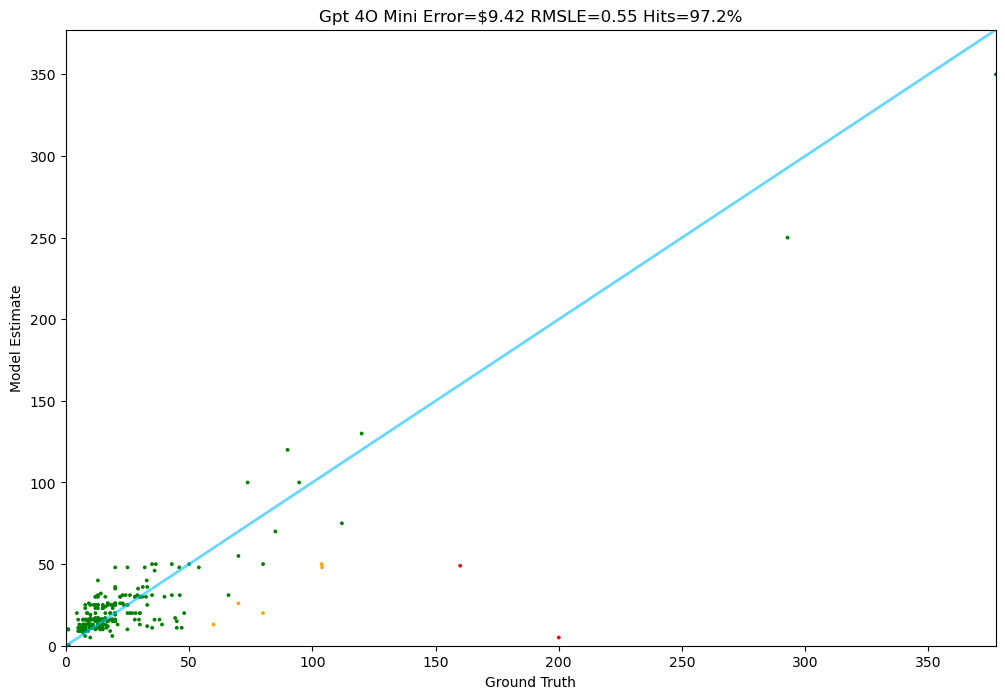

In [133]:
Tester.test(gpt_4o_mini, test)
